Question 1

Prompt:
I have a zip that contains daily files with SPX option prices. Note: you can use WINRAR software to open the SPX.rar file. The files contain these variables: Secid: unique identifier of the SPX underlying
Date: date of the observations
Exdate: expiry date of the option
Cp\_flag: C or P to indicate call or put
Strike: strike price of the option (K)
Mid: mid option price
Volume: option volume
Open\_interest: open\_interest of the option
Close: close price of the underlying (S)
Days: days to maturity
Sqrdays: days squared
P\_r: interest rate.
I do not want to unzip the file, just extract the content via python code. First: Part 1: Extract from the SPX.rar ONLY the file 20200302.csv. In this first part, you will only work with the file 20200302.csv. Provide python code to do this


In [1]:
# Step 1: Install required tools and libraries
!apt-get install -y unrar
!pip install -q pyunpack patool

# Step 2: Import necessary modules
import os
import shutil
import tempfile
import patoolib

# Step 3: Define filenames and paths
rar_file = "SPX.rar"  # Make sure the file is uploaded to the Colab environment
target_file = "20200302.csv"
output_dir = "/content/extracted_file"

# Step 4: Create temporary folder to extract all files
temp_dir = tempfile.mkdtemp()

# Step 5: Extract archive to temporary directory
patoolib.extract_archive(rar_file, outdir=temp_dir)

# Step 6: Search and copy ONLY the target file
found = False
for root, dirs, files in os.walk(temp_dir):
    if target_file in files:
        os.makedirs(output_dir, exist_ok=True)
        shutil.copy(os.path.join(root, target_file), os.path.join(output_dir, target_file))
        print(f"✅ {target_file} extracted to {output_dir}")
        found = True
        break

if not found:
    print(f"❌ File {target_file} not found in the archive.")

# (Optional) Preview the first few lines of the file
import pandas as pd
csv_path = os.path.join(output_dir, target_file)
if found:
    df = pd.read_csv(csv_path)
    print(df.head())


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.5 MB/s eta 0:00:00


INFO patool: Extracting SPX.rar ...
INFO:patool:Extracting SPX.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/SPX.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/SPX.rar
INFO patool: ... SPX.rar extracted to `/tmp/tmpkweil6k0'.
INFO:patool:... SPX.rar extracted to `/tmp/tmpkweil6k0'.


✅ 20200302.csv extracted to /content/extracted_file
    secid        date     exdate cp_flag  strike     mid  volume  \
0  108105  2020-03-02  04MAR2020       P    2940   7.100    8734   
1  108105  2020-03-02  04MAR2020       P    2150   0.025     926   
2  108105  2020-03-02  04MAR2020       C    3350   0.125      20   
3  108105  2020-03-02  04MAR2020       P    2425   0.100    2354   
4  108105  2020-03-02  04MAR2020       C    3140  16.600     250   

   open_interest    close  days  sqrdays       P_r  
0            538  3090.23     2        4  0.016293  
1           3703  3090.23     2        4  0.016293  
2           1855  3090.23     2        4  0.016293  
3            322  3090.23     2        4  0.016293  
4            255  3090.23     2        4  0.016293  


Now, I want you to compute python code to do: compute the implied volatilities of all options in the file using the BSM model. Assume no dividends. Implement two methods to compute the implied volatility and make sure you record the time it takes each method to compute implied volatilities:
i.	Newton-Raphson method
ii.	Bisection method. For each method show the time it takes to compute the implied volatility. Also, print the first 5 rows of implied volatilites for each method.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as si
import time
from tqdm.notebook import tqdm  # shows progress bars in Colab
tqdm.pandas()

In [3]:
def bs_price(S, K, T, r, sigma, cp_flag):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == 'C':
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    elif cp_flag == 'P':
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    else:
        return np.nan


In [4]:
def vega(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * si.norm.pdf(d1) * np.sqrt(T)


In [5]:
def implied_vol_newton(market_price, S, K, T, r, cp_flag, tol=1e-6, max_iter=100):
    sigma = 0.2  # initial guess
    for _ in range(max_iter):
        price = bs_price(S, K, T, r, sigma, cp_flag)
        v = vega(S, K, T, r, sigma)
        if v == 0:
            return np.nan
        increment = (price - market_price) / v
        sigma -= increment
        if abs(increment) < tol:
            return sigma
    return np.nan


In [6]:
def implied_vol_bisection(market_price, S, K, T, r, cp_flag, tol=1e-6, max_iter=100):
    low = 1e-5
    high = 5.0
    for _ in range(max_iter):
        mid = (low + high) / 2
        price = bs_price(S, K, T, r, mid, cp_flag)
        if np.isnan(price):
            return np.nan
        if abs(price - market_price) < tol:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return np.nan


In [7]:
# Load the CSV file
file_path = "/content/extracted_file/20200302.csv"
df = pd.read_csv(file_path)

# Normalize column names
df.columns = df.columns.str.strip().str.lower()

# Filter rows with valid prices and maturity
df = df[(df['mid'] > 0) & (df['days'] > 0)].copy()
df['t'] = df['days'] / 365

# For testing purposes: limit to 500 rows
df = df.head(500)

# Optional: check column names if needed
# print(df.columns.tolist())


In [8]:
start = time.time()
df['iv_newton'] = df.progress_apply(lambda row: implied_vol_newton(
    row['mid'], row['close'], row['strike'], row['t'], row['p_r'], row['cp_flag']), axis=1)
time_newton = time.time() - start

print(f"\n⏱️ Newton-Raphson took: {time_newton:.2f} seconds")
print(df[['secid', 'date', 'strike', 'cp_flag', 'iv_newton']].head())

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-3-2954b1870689>:4: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))



⏱️ Newton-Raphson took: 0.68 seconds
    secid        date  strike cp_flag  iv_newton
0  108105  2020-03-02    2940       P        NaN
1  108105  2020-03-02    2150       P        NaN
2  108105  2020-03-02    3350       C        NaN
3  108105  2020-03-02    2425       P        NaN
4  108105  2020-03-02    3140       C   0.392166


In [9]:
start = time.time()
df['iv_bisection'] = df.progress_apply(lambda row: implied_vol_bisection(
    row['mid'], row['close'], row['strike'], row['t'], row['p_r'], row['cp_flag']), axis=1)
time_bisect = time.time() - start

print(f"\n⏱️ Bisection took: {time_bisect:.2f} seconds")
print(df[['secid', 'date', 'strike', 'cp_flag', 'iv_bisection']].head())

  0%|          | 0/500 [00:00<?, ?it/s]


⏱️ Bisection took: 3.19 seconds
    secid        date  strike cp_flag  iv_bisection
0  108105  2020-03-02    2940       P      0.563563
1  108105  2020-03-02    2150       P      1.446760
2  108105  2020-03-02    3350       C      0.412042
3  108105  2020-03-02    2425       P      1.108177
4  108105  2020-03-02    3140       C      0.392166


Now, I want you to provide python code to create a volatility smile graph. The graph should include: moneyness in the x-axis (strike/price) vs implied volatility for the lowest maturity in the y-axis. Use the implied volatility computed by the bisection method.
Include in the code above the following: Moneyness (K/S) vs Implied volatility for the maturity closest to 30 days. Make sure this is automated (i.e. do not hard code an expiry date in your code). This should be plotted in the same graph.

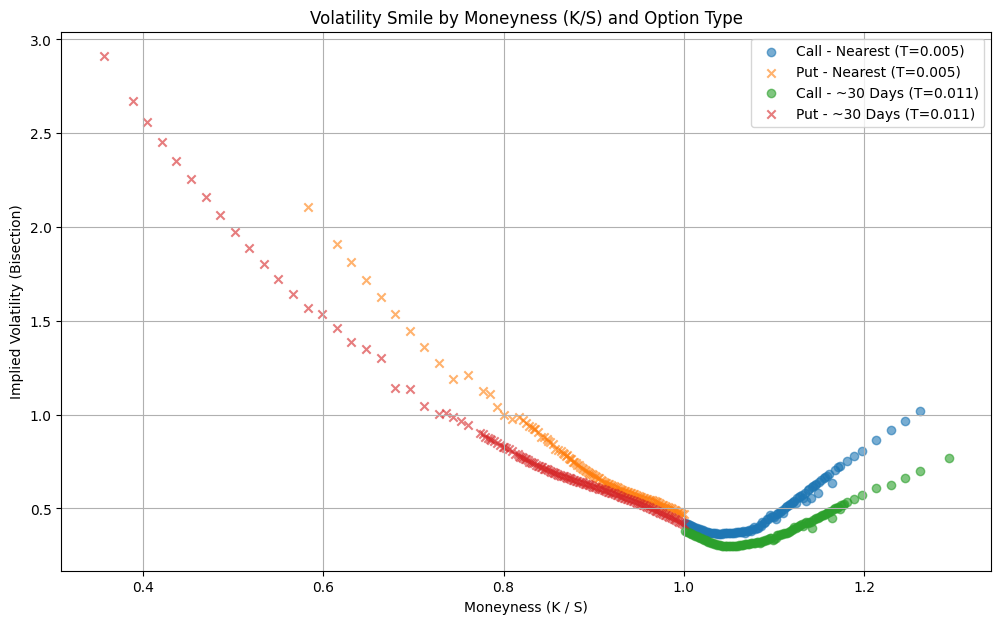

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------
# Step 1: Filter valid implied vol data
# ---------------------------------------
df_valid = df.dropna(subset=['iv_bisection']).copy()

# ---------------------------------------
# Step 2: Find maturity closest to 30 days
# ---------------------------------------
nearest_T = df_valid['t'].min()
target_T = 30 / 365
closest_T = df_valid['t'].iloc[(df_valid['t'] - target_T).abs().argsort()].iloc[0]

# ---------------------------------------
# Step 3: Create subsets and compute moneyness
# ---------------------------------------
# ✅ New function to filter only OTM options
def prepare_otm_subset(df_sub):
    df_sub['moneyness'] = df_sub['strike'] / df_sub['close']
    is_otm_call = (df_sub['cp_flag'] == 'C') & (df_sub['strike'] > df_sub['close'])
    is_otm_put  = (df_sub['cp_flag'] == 'P') & (df_sub['strike'] < df_sub['close'])
    return df_sub[is_otm_call | is_otm_put]

# Apply OTM filter to nearest and ~30-day maturity
df_nearest = prepare_otm_subset(df_valid[df_valid['t'] == nearest_T].copy())
df_30day   = prepare_otm_subset(df_valid[df_valid['t'] == closest_T].copy())

# ---------------------------------------
# Step 4: Plot both smiles by call/put
# ---------------------------------------
plt.figure(figsize=(12, 7))

# Nearest maturity
plt.scatter(df_nearest[df_nearest['cp_flag'] == 'C']['moneyness'],
            df_nearest[df_nearest['cp_flag'] == 'C']['iv_bisection'],
            label=f'Call - Nearest (T={nearest_T:.3f})', marker='o', alpha=0.6)

plt.scatter(df_nearest[df_nearest['cp_flag'] == 'P']['moneyness'],
            df_nearest[df_nearest['cp_flag'] == 'P']['iv_bisection'],
            label=f'Put - Nearest (T={nearest_T:.3f})', marker='x', alpha=0.6)

# ~30-day maturity
plt.scatter(df_30day[df_30day['cp_flag'] == 'C']['moneyness'],
            df_30day[df_30day['cp_flag'] == 'C']['iv_bisection'],
            label=f'Call - ~30 Days (T={closest_T:.3f})', marker='o', alpha=0.6)

plt.scatter(df_30day[df_30day['cp_flag'] == 'P']['moneyness'],
            df_30day[df_30day['cp_flag'] == 'P']['iv_bisection'],
            label=f'Put - ~30 Days (T={closest_T:.3f})', marker='x', alpha=0.6)

# ---------------------------------------
# Final plot formatting
# ---------------------------------------
plt.title('Volatility Smile by Moneyness (K/S) and Option Type')
plt.xlabel('Moneyness (K / S)')
plt.ylabel('Implied Volatility (Bisection)')
plt.grid(True)
plt.legend()
plt.show()


Part 2

Prompt:
In the second part we will compute implied volatilities for all the CSV files from the SPX.rar file. Imagine that at the end of every month you receive the SPX.rar file and that you must process this RAR file  to compute the IVs for all options every day. Before doing this for all the zip file, first: a)	Create a smaller file called SPX\_try.rar with 2-3 csv files (first 3). You MUST use a loop to process these csv files.
b)	Create one dataframe were you store all the option data from every day along with the IVs.
c)	You must process the RAR file automatically. Do NOT extract the rar file into my hard-drive. Instead, create code that does NOT extract the csv files, but that processes them on the fly. Provide python code to compute this for the first 3 files

In [ ]:
!apt-get install -y unrar > /dev/null
!pip install -q rarfile

# --------------------------------------------
# Step 3: Import required libraries (if not done yet)
# --------------------------------------------
import pandas as pd
import numpy as np
import rarfile
import io
from tqdm.notebook import tqdm
tqdm.pandas()

# --------------------------------------------
# Step 4: Process first 3 CSVs from SPX.rar
# Reuses functions: bs_price, vega, implied_vol_bisection
# --------------------------------------------
rar_path = "SPX.rar"
rf = rarfile.RarFile(rar_path)

# Get names of the first 3 CSVs
csv_files = sorted([f.filename for f in rf.infolist() if f.filename.endswith('.csv')])[:3]

all_data = []

for file_name in tqdm(csv_files, desc="Processing first 3 CSVs"):
    try:
        with rf.open(file_name) as f:
            df = pd.read_csv(io.TextIOWrapper(f, encoding='utf-8'))
            df.columns = df.columns.str.strip().str.lower()
            df = df[(df['mid'] > 0) & (df['days'] > 0)].copy()
            df['t'] = df['days'] / 365

            df['iv_bisection'] = df.progress_apply(lambda row: implied_vol_bisection(
                row['mid'], row['close'], row['strike'], row['t'], row['p_r'], row['cp_flag']), axis=1)

            df['source_file'] = file_name
            all_data.append(df)
    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

# Combine into one DataFrame
df_test = pd.concat(all_data, ignore_index=True)

# Preview result
print(df_test[['date', 'strike', 'cp_flag', 'iv_bisection', 'source_file']].head())


Processing first 3 CSVs:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9030 [00:00<?, ?it/s]

  0%|          | 0/9138 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

         date  strike cp_flag  iv_bisection   source_file
0  2020-03-02    2940       P      0.563563  20200302.csv
1  2020-03-02    2150       P      1.446760  20200302.csv
2  2020-03-02    3350       C      0.412042  20200302.csv
3  2020-03-02    2425       P      1.108177  20200302.csv
4  2020-03-02    3140       C      0.392166  20200302.csv


Now, compute code to create the graph computed before (moneyness vs IV) with the same assumptions. The graph should be the same as the one computed before, but it should allow me to change the desired date in the code to obtain the graph for that given date. Make sure the assumptions are the same: IV's for the maturities stated, moneyness definition, only OTC)

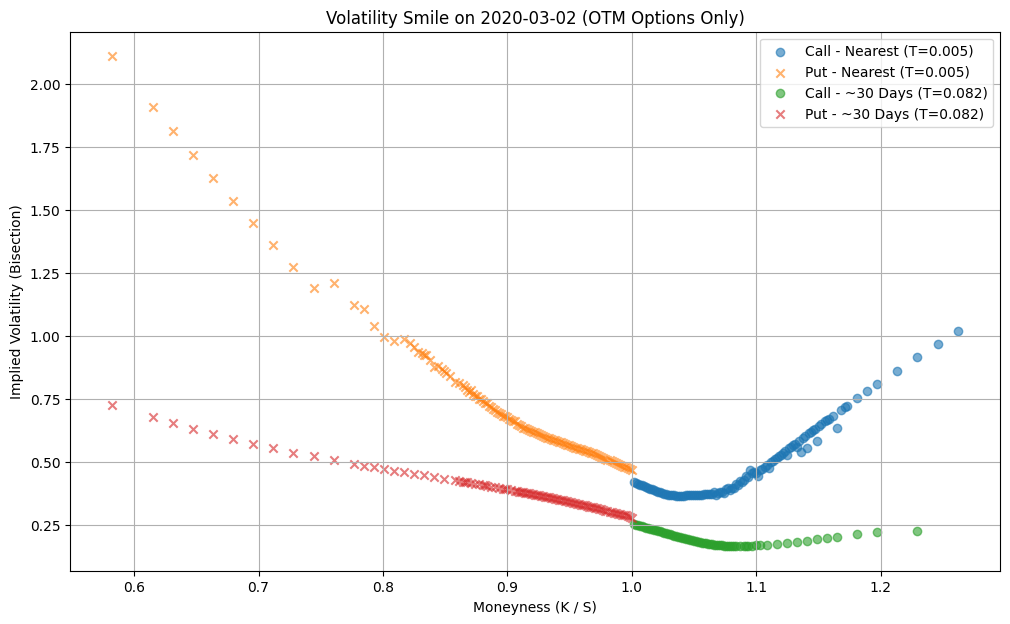

In [ ]:
import matplotlib.pyplot as plt

# --------------------------------------------
# ✅ Setup: use df_test instead of df_all
# --------------------------------------------
df_all = df_test.copy()  # Assign df_test to df_all for plotting

# Ensure date column is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'])

# --------------------------------------------
# ✅ Choose the date you want to plot
# --------------------------------------------
desired_date = '2020-03-02'  # <-- Change this as needed

# Filter for the selected date
selected_data = df_all[df_all['date'] == desired_date].copy()

# --------------------------------------------
# ✅ Define OTM filter and moneyness
# --------------------------------------------
def prepare_otm_subset(df_sub):
    df_sub['moneyness'] = df_sub['strike'] / df_sub['close']
    is_otm_call = (df_sub['cp_flag'] == 'C') & (df_sub['strike'] > df_sub['close'])
    is_otm_put  = (df_sub['cp_flag'] == 'P') & (df_sub['strike'] < df_sub['close'])
    return df_sub[is_otm_call | is_otm_put]

# Clean and filter data
selected_data = selected_data.dropna(subset=['iv_bisection'])
selected_data = prepare_otm_subset(selected_data)

# --------------------------------------------
# ✅ Identify nearest and ~30-day maturities
# --------------------------------------------
nearest_T = selected_data['t'].min()
target_T = 30 / 365
closest_T = selected_data['t'].iloc[(selected_data['t'] - target_T).abs().argsort()].iloc[0]

df_nearest = selected_data[selected_data['t'] == nearest_T].copy()
df_30day   = selected_data[selected_data['t'] == closest_T].copy()

# --------------------------------------------
# ✅ Plot the volatility smiles
# --------------------------------------------
plt.figure(figsize=(12, 7))

# Nearest maturity
plt.scatter(df_nearest[df_nearest['cp_flag'] == 'C']['moneyness'],
            df_nearest[df_nearest['cp_flag'] == 'C']['iv_bisection'],
            label=f'Call - Nearest (T={nearest_T:.3f})', marker='o', alpha=0.6)

plt.scatter(df_nearest[df_nearest['cp_flag'] == 'P']['moneyness'],
            df_nearest[df_nearest['cp_flag'] == 'P']['iv_bisection'],
            label=f'Put - Nearest (T={nearest_T:.3f})', marker='x', alpha=0.6)

# ~30-day maturity
plt.scatter(df_30day[df_30day['cp_flag'] == 'C']['moneyness'],
            df_30day[df_30day['cp_flag'] == 'C']['iv_bisection'],
            label=f'Call - ~30 Days (T={closest_T:.3f})', marker='o', alpha=0.6)

plt.scatter(df_30day[df_30day['cp_flag'] == 'P']['moneyness'],
            df_30day[df_30day['cp_flag'] == 'P']['iv_bisection'],
            label=f'Put - ~30 Days (T={closest_T:.3f})', marker='x', alpha=0.6)

plt.title(f'Volatility Smile on {desired_date} (OTM Options Only)')
plt.xlabel('Moneyness (K / S)')
plt.ylabel('Implied Volatility (Bisection)')
plt.grid(True)
plt.legend()
plt.show()

Now, compute python code to process on the fly (do not extract the csv files) for all the zip file. Also, provide separately code to compute the same graph with the same assumptions as the one in the last question.

In [12]:
# Install rarfile package to read .rar files
!apt-get install -y unrar > /dev/null
!pip install -q rarfile


In [13]:
# --------------------------------------------
# Assumes: SPX.rar is uploaded
# --------------------------------------------
import pandas as pd
import numpy as np
import rarfile
import io
from tqdm.notebook import tqdm
tqdm.pandas()

# --------------------------------------------
# Reuse previously defined function:
# bs_price(...) and implied_vol_bisection(...)
# --------------------------------------------

# Open RAR file
rar_path = "SPX.rar"
rf = rarfile.RarFile(rar_path)

# Get all CSV file names
csv_files = sorted([f.filename for f in rf.infolist() if f.filename.endswith('.csv')])

# Process all CSVs on the fly
all_data = []

for file_name in tqdm(csv_files, desc="Processing ALL CSVs in RAR"):
    try:
        with rf.open(file_name) as f:
            df = pd.read_csv(io.TextIOWrapper(f, encoding='utf-8'))
            df.columns = df.columns.str.strip().str.lower()
            df = df[(df['mid'] > 0) & (df['days'] > 0)].copy()
            df['t'] = df['days'] / 365

            df['iv_bisection'] = df.progress_apply(lambda row: implied_vol_bisection(
                row['mid'], row['close'], row['strike'], row['t'], row['p_r'], row['cp_flag']), axis=1)

            df['source_file'] = file_name
            all_data.append(df)
    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)

Processing ALL CSVs in RAR:   0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/9030 [00:00<?, ?it/s]

  0%|          | 0/9138 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9148 [00:00<?, ?it/s]

  0%|          | 0/9039 [00:00<?, ?it/s]

  0%|          | 0/8757 [00:00<?, ?it/s]

  0%|          | 0/9992 [00:00<?, ?it/s]

  0%|          | 0/9745 [00:00<?, ?it/s]

  0%|          | 0/9898 [00:00<?, ?it/s]

  0%|          | 0/9795 [00:00<?, ?it/s]

  0%|          | 0/9623 [00:00<?, ?it/s]

  0%|          | 0/10405 [00:00<?, ?it/s]

  0%|          | 0/10030 [00:00<?, ?it/s]

  0%|          | 0/9837 [00:00<?, ?it/s]

  0%|          | 0/9470 [00:00<?, ?it/s]

  0%|          | 0/9359 [00:00<?, ?it/s]

  0%|          | 0/10143 [00:00<?, ?it/s]

  0%|          | 0/9945 [00:00<?, ?it/s]

  0%|          | 0/9930 [00:00<?, ?it/s]

  0%|          | 0/9739 [00:00<?, ?it/s]

  0%|          | 0/9436 [00:00<?, ?it/s]

  0%|          | 0/9160 [00:00<?, ?it/s]

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
df_all.to_pickle("/content/drive/MyDrive/SPX_full_IVs.pkl")

Question 2

Prompt:
Now, check this Word, especifically the regression in question 2. Please transcribe it for me.
Now, compute python code to run this regression with the first date of the zip file ONLY (2020-03-02). Show the coefficients.

In [18]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# --------------------------------------------
# Prepare the dataset for 2020-03-02
# --------------------------------------------
df_all['date'] = pd.to_datetime(df_all['date'])
df_reg = df_all[df_all['date'] == '2020-03-02'].copy()

# --------------------------------------------
# Compute moneyness and drop missing IVs
# --------------------------------------------
df_reg['moneyness'] = df_reg['strike'] / df_reg['close']
df_reg = df_reg.dropna(subset=['iv_bisection'])

# --------------------------------------------
# Build corrected regression variables
# --------------------------------------------
X = pd.DataFrame({
    'const': 1,
    'moneyness': df_reg['moneyness'],
    'moneyness_sq': df_reg['moneyness'] ** 2,
    'T': df_reg['t'],
    'T2': df_reg['t'] ** 2,                        # corrected term
    'T_moneyness': df_reg['t'] * df_reg['moneyness']
})

y = df_reg['iv_bisection']

# --------------------------------------------
# Run the regression
# --------------------------------------------
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           iv_bisection   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     3740.
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        19:32:35   Log-Likelihood:                 6889.1
No. Observations:                9030   AIC:                        -1.377e+04
Df Residuals:                    9024   BIC:                        -1.372e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.7583      0.017    102.388   

Now, compute python code to run the same regression as before for all the days in the df\_all dataframe. Store all the coefficcients for each day in a new dataframe along with the t-statistics for every coefficient of every day. Then, provide code to compute two graphs: one for the coefficients at each date and one for the t-statistics of each coefficient. The idea is to see the change over time of the coefficients and of their t-statistics.

In [19]:
# Ensure 'date' column is datetime
df_all['date'] = pd.to_datetime(df_all['date'])

# Get unique dates
unique_dates = sorted(df_all['date'].unique())

# Lists to store daily regression results
coef_list = []
tstat_list = []

# Loop through each date
for date in unique_dates:
    df_day = df_all[df_all['date'] == date].copy()
    df_day['moneyness'] = df_day['strike'] / df_day['close']
    df_day = df_day.dropna(subset=['iv_bisection'])

    # Regression variables
    X = pd.DataFrame({
        'const': 1,
        'moneyness': df_day['moneyness'],
        'moneyness_sq': df_day['moneyness'] ** 2,
        'T': df_day['t'],
        'T2': df_day['t'] ** 2,
        'T_moneyness': df_day['t'] * df_day['moneyness']
    })
    y = df_day['iv_bisection']

    try:
        model = sm.OLS(y, X).fit()
        coef_list.append({'date': date, **model.params.to_dict()})
        tstat_list.append({'date': date, **model.tvalues.to_dict()})
    except Exception as e:
        print(f"Regression failed for {date}: {e}")

In [20]:
# Coefficients and t-statistics by date
coef_df = pd.DataFrame(coef_list).set_index('date')
tstat_df = pd.DataFrame(tstat_list).set_index('date')

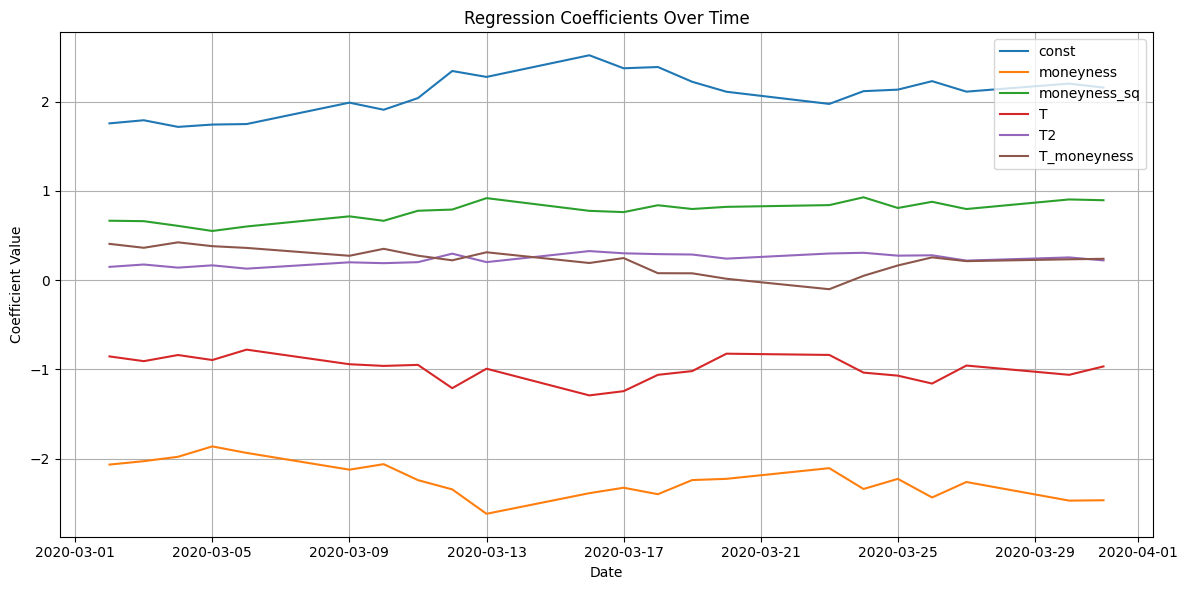

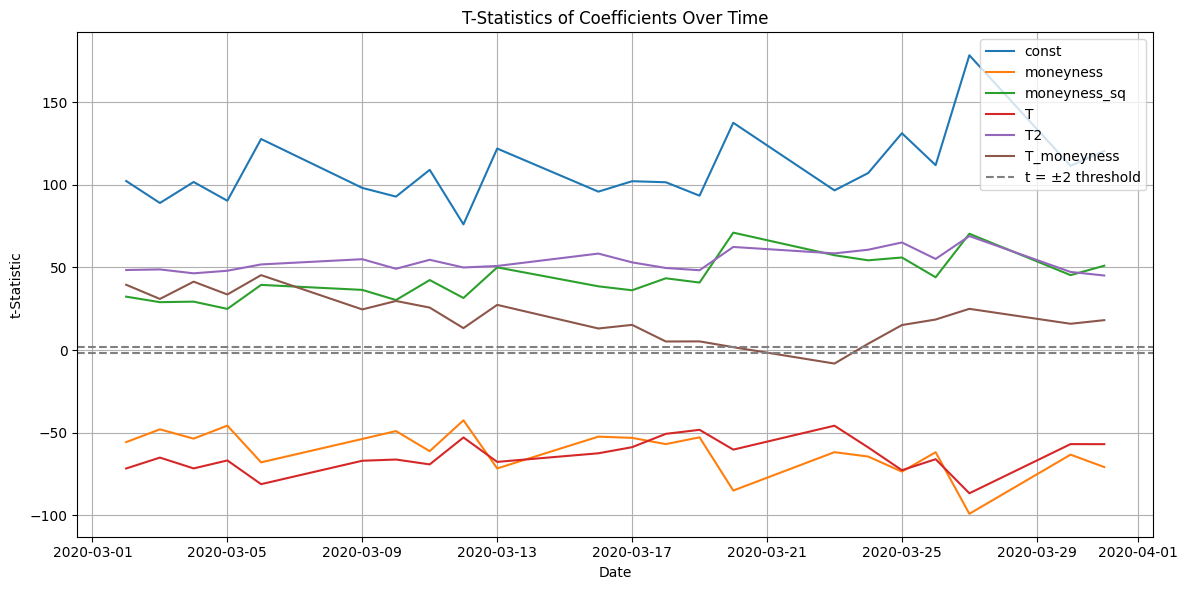

In [21]:
plt.figure(figsize=(12, 6))
for col in coef_df.columns:
    plt.plot(coef_df.index, coef_df[col], label=col)
plt.title("Regression Coefficients Over Time")
plt.xlabel("Date")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for col in tstat_df.columns:
    plt.plot(tstat_df.index, tstat_df[col], label=col)
plt.axhline(y=2, color='gray', linestyle='--', label='t = ±2 threshold')
plt.axhline(y=-2, color='gray', linestyle='--')
plt.title("T-Statistics of Coefficients Over Time")
plt.xlabel("Date")
plt.ylabel("t-Statistic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Ensure the index is datetime
coef_df.index = pd.to_datetime(coef_df.index)

# Set the date of interest
target_date = pd.to_datetime('2020-03-11')

# Display the coefficients for that date
if target_date in coef_df.index:
    print(f"Regression coefficients for {target_date.date()}:")
    print(coef_df.loc[target_date])
else:
    print(f"No regression results found for {target_date.date()}.")

Regression coefficients for 2020-03-11:
const           2.041787
moneyness      -2.241811
moneyness_sq    0.778488
T              -0.949693
T2              0.202147
T_moneyness     0.274837
Name: 2020-03-11 00:00:00, dtype: float64
